<a href="https://colab.research.google.com/github/dipnarayan501/CNN/blob/main/DL_CNN_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Link to download dataset
#!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import shutil
import os
import random
try:
    shutil.rmtree("inaturalist_12K")
except:
    pass

    
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip

try:
    os.remove("nature_12K.zip")
except:
    pass
try:
    shutil.rmtree("inaturalist_12K/validation/")
except:
    pass


temp = os.listdir("inaturalist_12K/train")

class_names = [name for name in temp if name != ".DS_Store"]

#Splitting train dataset into train and validation
validation_split = 0.1 #splitting dataset 10%
def spliting_train_data(validation_split = 0.1):
  os.mkdir("inaturalist_12K/validation/")
  for each_class in class_names:
      os.mkdir("inaturalist_12K/validation/"+each_class)
      train_images = os.listdir("inaturalist_12K/train/"+each_class)
      train_images_per_class = list(train_images)
      #print(len(train_images_per_class))
      random.shuffle(train_images_per_class) # Shuffle the training images

      validation_images_per_class = train_images_per_class[:round(validation_split*len(train_images_per_class))]
      #print(len(validation_images_per_class))

      for im in validation_images_per_class:
          shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im)
#Callling spllit function
spliting_train_data(validation_split)

In [ ]:
train = 0
val = 0
test = 0
print("Printing Number of images in each Dataset")
for each_class in class_names:
      
      train_images = os.listdir("inaturalist_12K/train/"+each_class)
      train+=len(list(train_images))

      validation_images = os.listdir("inaturalist_12K/validation/"+each_class)
      
      val+=len(list(validation_images))

      test_images = os.listdir("inaturalist_12K/val/"+each_class)
      
      test+=len(list(test_images))
      
print("Training examples" , train)
print("Validation Examples = ", val)
print("test examples = ", test)

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization


!pip install wandb
import wandb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback
from keras.utils.vis_utils import plot_model
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt


In [7]:
#Path to dataset directory
data_dir = "inaturalist_12K"

#Data Generation Code
def data_preparation(data_dir , data_augmentation , batch_size):
  train_dir = os.path.join(data_dir, "train")
  val_dir = os.path.join(data_dir, "validation")
  test_dir = os.path.join(data_dir, "val")
  if data_augmentation == True:
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      height_shift_range=0.2,
                                      width_shift_range=0.2,
                                      horizontal_flip=True,
                                      zoom_range=0.2,
                                      fill_mode="nearest")
  else:
      train_datagen = ImageDataGenerator(rescale=1./255)
  val_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)


  train_generator = train_datagen.flow_from_directory(
          train_dir,
          target_size=(224, 224),
          shuffle=True,
          color_mode="rgb",
          batch_size=batch_size,
          class_mode='categorical')

  val_generator = val_datagen.flow_from_directory(
          val_dir,
          target_size=(224, 224),
          shuffle=True,
          color_mode="rgb",
          batch_size=batch_size,
          class_mode='categorical')
  
  test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size= (224, 224),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical')

  
  
  return train_generator , val_generator, test_generator
#train_generator , val_generator, test_generator = data_preparation(data_dir , data_augmentation = True , batch_size = 250)


In [8]:
def CNN(filter,filter_size,dense_layer,dropout, normalisation ):


  model = Sequential()

  #Adding 1st Layer 
  model.add(Conv2D(filter[0],filter_size[0],input_shape=(224, 224,3)))
  if normalisation ==True:
      model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides = (2, 2), padding='valid'))
  #Adding 2nd layer
  model.add(Conv2D(filter[1],filter_size[1]))
  if normalisation == True:
      model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides = (2, 2), padding='valid'))
  #Adding third layer
  model.add(Conv2D(filter[2],filter_size[2]))
  if normalisation == True:
      model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides = (2, 2), padding='valid'))
 #Adding fourth layer
  model.add(Conv2D(filter[3],filter_size[3]))
  if normalisation == True:
      model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides = (2, 2), padding='valid'))
 #Adding fifth layer
  model.add(Conv2D(filter[4],filter_size[4]))
  if normalisation == True:
      model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides = (2, 2), padding='valid'))
 #Flattening
  model.add(Flatten())
  #Adding dense layer
  model.add(Dense(dense_layer, activation='relu'))
  #Adding dropout layer
  model.add(Dropout(dropout))
  #Adding softmax layer
  model.add(Dense(10, activation='softmax'))
 

  #model.summary()
  return model

In [10]:
#Sweep function
def train():
    # Default values for hyper-parameters
    config_defaults = {
        "data_augmentation": True,
        "batch_size": 250,
        "normalisation": True,
        "dropout": 0.1,
        "filter": [16, 32, 64, 128, 256],
        "dense_layer": 256,
        "learning_rate": 0.0001, 
        "filters_size": [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
        "epochs "  : 5
    }

    # Initializing a new run
    wandb.init(config=config_defaults)
    

    config = wandb.config

    # Local variables
    filter = config.filter
    data_augmentation = config.data_augmentation
    batch_size = config.batch_size
    normalisation = config.normalisation
    dropout = config.dropout
    dense_layer = config.dense_layer
    filters_size = config.filters_size
    learning_rate = config.learning_rate
    epochs = config.epochs
    
    # Displaying hyperparameters
    run_name = "aug_{}_bs_{}_norm_{}_dropout_{}_dense_{}_fil_{}_size_{}".format(data_augmentation, batch_size, normalisation, dropout, dense_layer, filter, filters_size)
    print(run_name)

    # Creating the data generators
    train_generator , val_generator, test_generator = data_preparation(data_dir , data_augmentation = data_augmentation , batch_size = batch_size)
    #Initiliasing model
    model = CNN(filter,filters_size,dense_layer,dropout, normalisation)


    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# Early Stopping 
    earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

    # To save the model with best validation accuracy
    checkpoint = ModelCheckpoint('bestmodel.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    #Training model
    history = model.fit(train_generator,
                        steps_per_epoch = train_generator.n//train_generator.batch_size,
                        validation_data = val_generator,
                        validation_steps = val_generator.n//val_generator.batch_size,
                        epochs=epochs, verbose = 2, 
                        callbacks=[WandbCallback(), earlyStopping, checkpoint])

    
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

In [11]:
# Sweep configuration
sweep_config = {
  "name": "CNN Part A",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "bayes",
  "parameters": {
        "data_augmentation": {
            "values": [True, False]
        },
        "batch_size": {
            "values": [128, 256]
        },
         "epochs": {
            "values": [10]
        },
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "normalisation": {
            "values": [True , False]
        },
        "dropout": {
            "values": [0, 0.1, 0.2,0.4]
        },
        "filter": {
            "values": [[16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [32, 32, 32, 32, 32],
                       [256, 128, 64, 32, 16]]
        },
        "dense_layer": {
            "values": [128, 256]
        },
        "filters_size": {
            "values": [[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
                       [(5, 5), (5, 5), (5, 5), (5, 5), (5, 5)],
                       [(7, 7), (5, 5), (5, 5), (3, 3), (3, 3)],
                       [(3, 3), (5, 5), (3, 3), (5, 5), (7, 7)]]
        }
    }
}





In [ ]:
#configuring wandb
%pip install wandb -q
import wandb
wandb.login()

#Generate sweep_id
sweep_id = wandb.sweep(sweep_config, entity="fdl-moni_dip", project="test_cnn_part_a")



In [ ]:
id = '8qu84xzv'
wandb.agent(id, train, entity="fdl-moni_dip", project="test_cnn_part_a" , count=40)

Testing for test dataset for best Configuration obtained

In [ ]:
#Best Configuration
data_augmentation = False
batch_size = 128
dropout = 0.1
filter = [32, 32, 32, 32, 32]
filters_size = [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
dense_layer = 256
normalisation  = True
learning_rate = 0.001
epochs = 15     #Change epochs from 10 to 15

train_generator , val_generator, test_generator = data_preparation(data_dir , data_augmentation = data_augmentation , batch_size = batch_size)
model = CNN(filter,filters_size,dense_layer,dropout, normalisation)


model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
# Early Stopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

    # To save the model with best validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

history = model.fit(train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_data = val_generator,
                    validation_steps = val_generator.n//val_generator.batch_size,
                    epochs=epochs, verbose = 2
                    ,callbacks=[earlyStopping, checkpoint])


model.save("best_model.h5")


Note: Test accuracy might differ a bit as we are shuffling dataset fro training purpose unless you are using best_model.h5 provided in github

In [ ]:

data_augmentation = False
batch_size = 128

train_generator , val_generator, test_generator = data_preparation(data_dir , data_augmentation = data_augmentation , batch_size = batch_size)
# Load the saved model
from keras.models import load_model
bestmodel= load_model("best_model.h5")
# Evaluation on the test set
loss , accuracy = bestmodel.evaluate(test_generator)
print(f"Testing accuracy = {accuracy*100} %")

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
16/16 [==============================] - 65s 4s/step - loss: 2.0739 - accuracy: 0.3600
Testing accuracy = 36.000001430511475 %


In [ ]:
#configuring wandb
%pip install wandb -q
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Plotting Filters

(3, 3, 32)


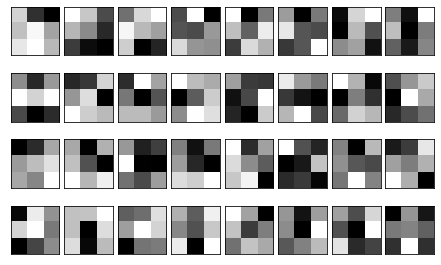

In [ ]:
# load the model
from keras.models import load_model
model = keras.models.load_model('best_model.h5')

#model.summary()
filters, biases = model.layers[0].get_weights()

# visualize the filters
# add the filters along depth dimension
filters = np.sum(filters, axis = 0)

# normalize the values between 0 to 1
#f_min, f_max = filters.min(), filters.max()
filters = (filters - filters.min()) / (filters.max() - filters.min())
print(filters.shape)

plt.figure()
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.1, wspace=.1)
for i in range(32):
		plt.subplot(4, 8, i + 1)
		plt.imshow(filters[:,:,i], cmap=plt.cm.gray)
		plt.xticks(())
		plt.yticks(())
plt.savefig("filters.png")
plt.show()




Plooting images after muultiplying with multiple filters

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
(1, 222, 222, 32)


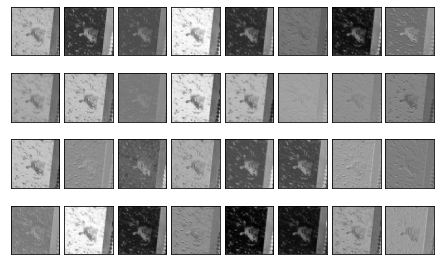

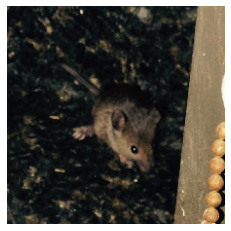

In [ ]:
train_generator , val_generator, test_generator = data_preparation(data_dir , data_augmentation = True , batch_size = 128)
batchX, batchy = test_generator.next()
sample = batchX[random.randint(0, len(batchX))]
sample = np.expand_dims(sample, axis=0)
first_layer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
out = first_layer.predict(sample)
print(out.shape)

plt.figure()
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.1, wspace=.1)
for i in range(32):
		plt.subplot(4, 8, i + 1)
		plt.imshow(out[0, :, :, i], cmap='gray')
		plt.xticks(())
		plt.yticks(())
  
plt.savefig("image_with_multiple_filters.png") 
plt.show()

plt.axis('off')
plt.imshow(sample[0])
plt.savefig("filter_image.png")
plt.show()


Test images predictions

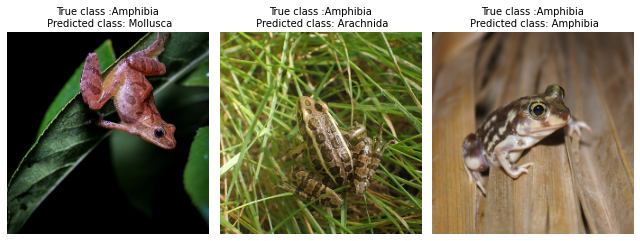

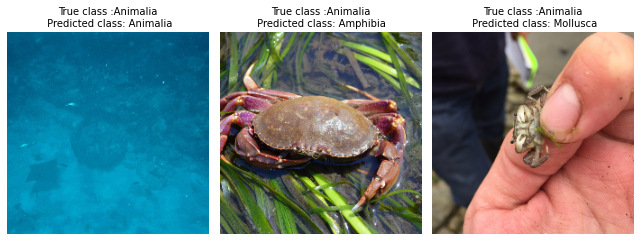

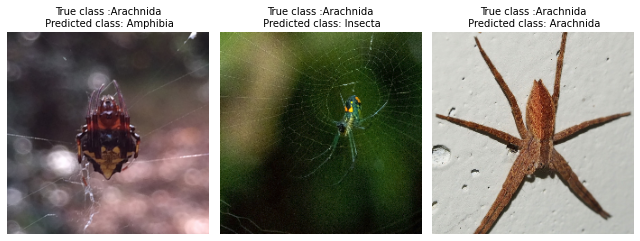

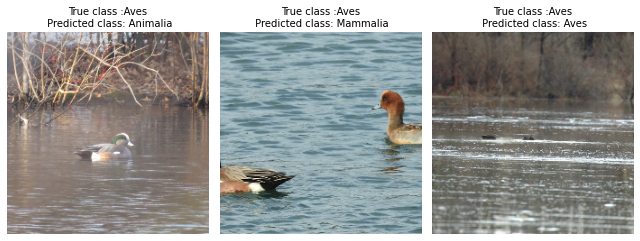

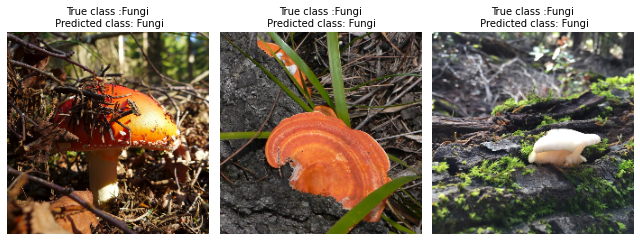

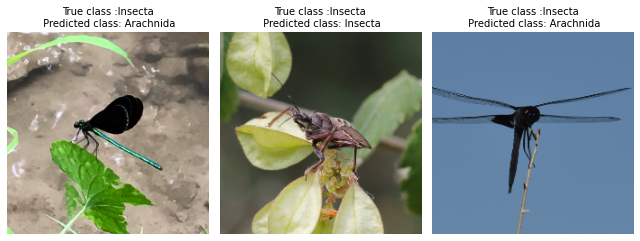

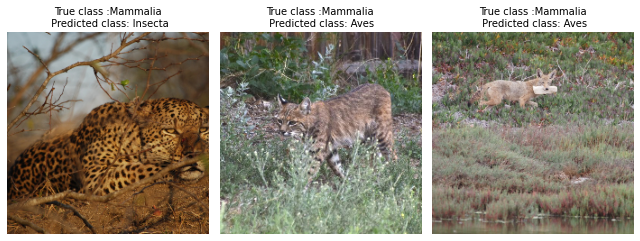

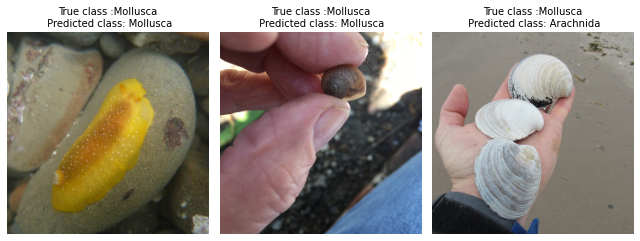

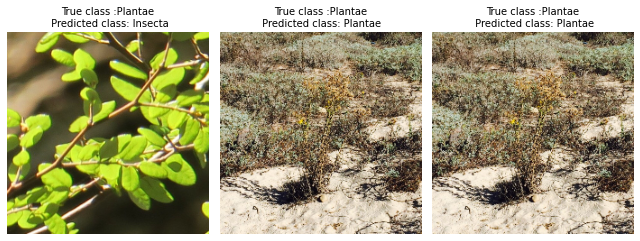

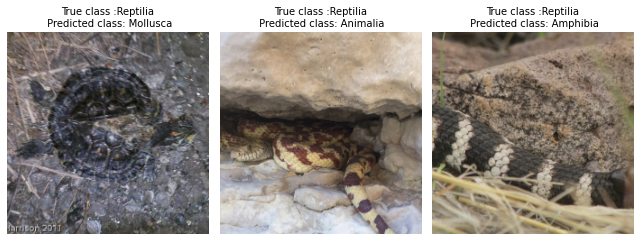

In [ ]:
#Loading models
from keras.models import load_model
model = keras.models.load_model('best_model.h5')

# Retrieve names of class  in alphabetical order
class_names_dict = train_generator.class_indices
class_names = class_names_dict.keys()
index_to_name = dict([(class_names_dict[key], key) for key in class_names_dict])

sample_images = []
for class_name in class_names:
      
    test_images = os.listdir("inaturalist_12K/val/"+class_name)
    random_indices = np.random.randint(0, 90 , 3)
      
    plt.figure(figsize=(9, 6))
    j = 0
    for i, ind in enumerate(random_indices):
        image = plt.imread("inaturalist_12K/val/"+class_name+"/"+test_images[ind])
          # Resizing input image 
        image_processed = keras.preprocessing.image.smart_resize(image, (224,224))/255.0
          # Predicting the class
        prediction = np.argmax(model.predict(np.array([image_processed])), axis=-1)[0]
          # Converting  the index to the class
        predicted_class = index_to_name[prediction]
        plt.subplot(1, 3, i+1)
        k=plt.imshow(image_processed)
        plt.axis("off")
        plt.title(f"True class :{class_name}\n Predicted class: {predicted_class}", size=10)
        j+=1
    plt.tight_layout() 
    plt.savefig("test_images_prediction"+str(class_name)+".png")
plt.show(k)

Guided Propogation Code here

In [ ]:
from keras.models import load_model
model = keras.models.load_model('best_model.h5')

# Choose a random image from the dataset
plt.figure(figsize=(100,100))
random_class = os.listdir("inaturalist_12K/train")[np.random.randint(0, 10)]
random_class_images = os.listdir("inaturalist_12K/train/"+random_class)
random_image = random_class_images[np.random.randint(0, len(random_class_images))]

# Load the random image that we will use for guided backpropagation
img = tf.keras.preprocessing.image.load_img("inaturalist_12K/train/"+random_class+"/"+random_image,
                                            target_size=(224, 224))



@tf.custom_gradient
def guided_back_ReLU(x):
  # if dy i.e the value of gradient coming into this layer is < 0 then ignore relu and pass 0
  # otherwise apply Relu and multiply it with the gradient dy coming here
  def grad(dy) :
    return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
  return tf.nn.relu(x), grad

# This custom model has the 5th convolutional layer as its final layer
guided_backprop_model = tf.keras.models.Model(inputs = [model.inputs], outputs = [model.get_layer(index=-8).output])

model_layers = guided_backprop_model.layers[1:]


for layer in model_layers :
  if hasattr(layer, 'activation') :
    if layer.activation == tf.keras.activations.relu :
      layer.activation = guided_back_ReLU

# The shape of the layer
conv_shape = model.layers[-8].output.shape[1:]
num_neurons = 10

for i in range(num_neurons):
    # random pixel
    neuron_index_x = np.random.randint(0, conv_shape[0])
    neuron_index_y = np.random.randint(0, conv_shape[1])
    neuron_index_z = np.random.randint(0, conv_shape[2])

    # Mask to focus on the outputs of only one neuron 
    masking_matrix = np.zeros((1, *conv_shape), dtype="float")
    masking_matrix[0, neuron_index_x, neuron_index_y, neuron_index_z] = 1

    # Calculating the gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.array([np.array(img)]), tf.float32)
        tape.watch(inputs)
        outputs = guided_backprop_model(inputs) * masking_matrix

    grads_visualize = tape.gradient(outputs, inputs)[0]

    # Visualize the output of guided backpropagation
    img_prop = np.dstack((grads_visualize[:, :, 0], grads_visualize[:, :, 1], grads_visualize[:, :, 2],)) 

    # Normalising     
    img_prop = (img_prop - np.min(img_prop))/img_prop.max()
    
    plt.subplot(10, 1, i+1)
    gp = plt.imshow(img_prop)
    plt.axis("off")
plt.savefig("Guided_propogation.png")
plt.show(gp)

plt.imshow(img)
plt.savefig("propogation_image.png")


In [ ]:
wandb.init(project="guiged_prop_images", entity="fdl-moni_dip", name="test")


In [ ]:
wandb.log({"image": wandb.Image(img)})
wandb.log({"Guided Prop images": wandb.Image(gp)})